# Regession

The goal of this notebook is to make a time series regression for annual total days, # events, intensity, duration, severity, etc. at the global scale, regional, country and city level

#### Dependencie

In [89]:
import pandas as pd
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm

#### Files

In [2]:
DATA_IN = fn = "/home/cascade/projects/data_out_urbanheat/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FN = 'All_data20191109_final.csv'
df = pd.read_csv(DATA_IN+FN)

In [3]:
df.columns

Index(['Unnamed: 0', 'CTR_MN_NM', 'Event_ID', 'GCPNT_LAT', 'GCPNT_LON',
       'ID_HDC_G0', 'avg_intensity', 'avg_temp', 'duration', 'event_dates',
       'intensity', 'intermediate-region', 'region', 'sub-region', 'tmax',
       'tot_intensity', 'total_days', 'year', 'start_date'],
      dtype='object')

In [4]:
df['severity'] = df['tot_intensity'] * df['duration']


# What is the slope of the heat wave characteristics over time?

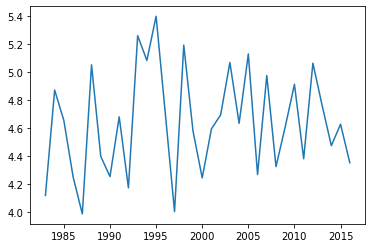

In [7]:
data = df.groupby(['year'])['duration'].mean()
plt.plot(data)

#### Frequency by region

Text(0, 0.5, 'Frequency of heat waves per year')

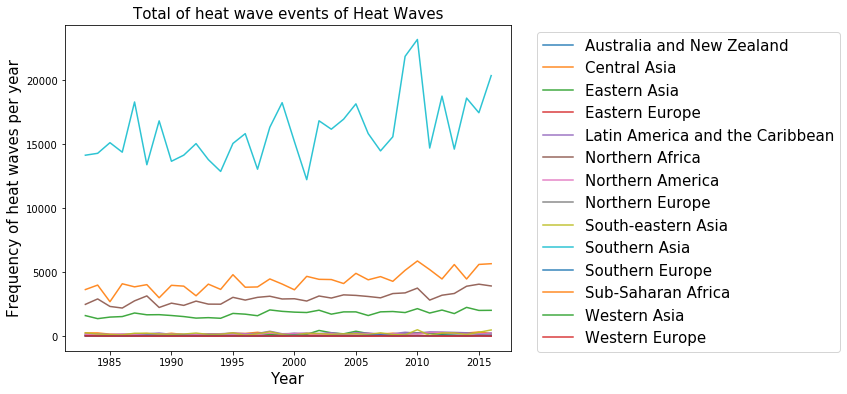

In [12]:
# plot by region 
ylabel = 'Frequency of heat waves per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.groupby('year')['ID_HDC_G0'].count()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Total of heat wave events of Heat Waves', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)
#plt.ylabel('Number of Heat Waves', fontsize = 15)

#### Duration by region

Text(0, 0.5, 'Annual average duration of heat waves per year')

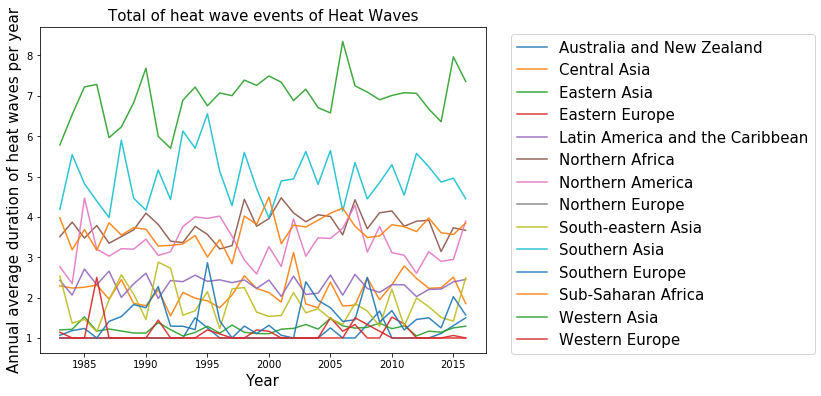

In [14]:
# plot by region 
ylabel = 'Annual average duration of heat waves per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.groupby('year')['duration'].mean()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Total of heat wave events of Heat Waves', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)
#plt.ylabel('Number of Heat Waves', fontsize = 15)

#### Severity by region

Text(0, 0.5, 'Annual average severity of heat waves per year')

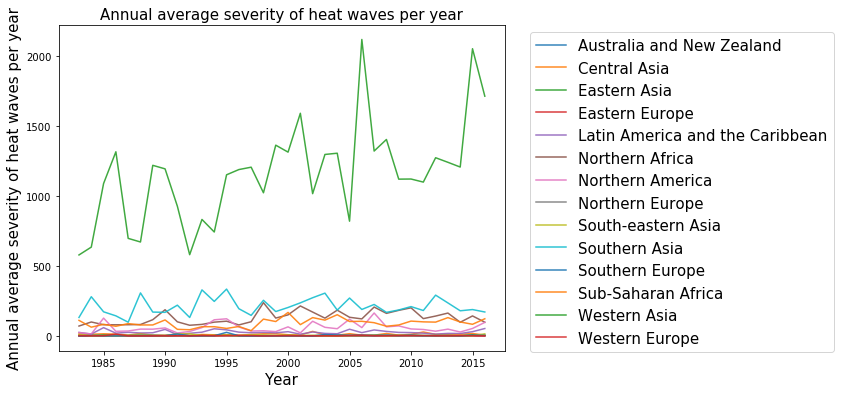

In [58]:
# plot by region 
ylabel = 'Annual average severity of heat waves per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.groupby('year')['severity'].mean()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Annual average severity of heat waves per year', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)
#plt.ylabel('Number of Heat Waves', fontsize = 15)

#### Intensity by region

Text(0, 0.5, 'Annual average total intensity of heat waves per year')

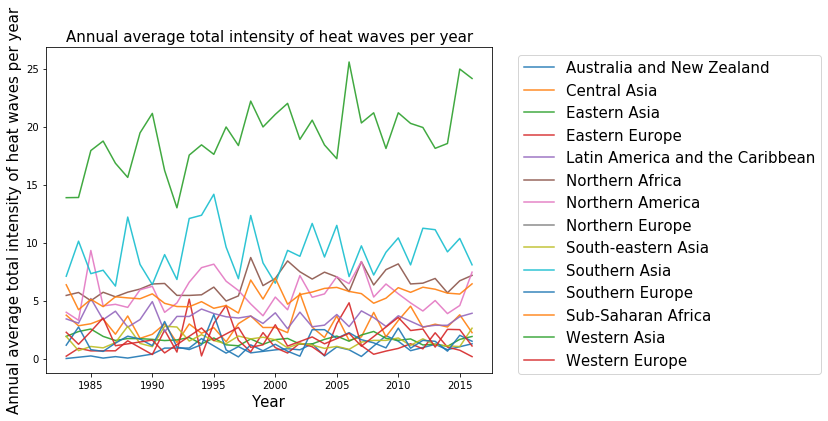

In [60]:
# plot by region 
ylabel = 'Annual average total intensity of heat waves per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.groupby('year')['tot_intensity'].mean()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Annual average total intensity of heat waves per year', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)
#plt.ylabel('Number of Heat Waves', fontsize = 15)

#### Days per year by region

Text(0, 0.5, 'Avg number of days per year')

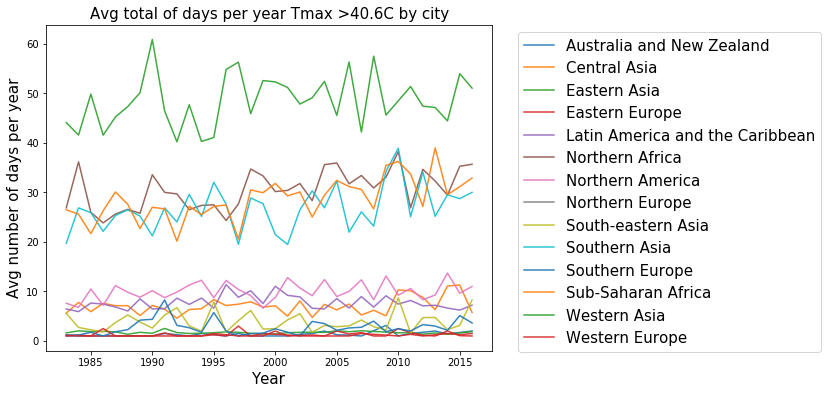

In [59]:
# plot by region 
ylabel = 'Avg number of days per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first')
    data = data.groupby('year')['total_days'].mean()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Avg total of days per year Tmax >40.6C by city', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)


# Plots by each event start date

In [48]:
india = df[df['CTR_MN_NM'] == 'India']

In [49]:
y = india['duration']
x = pd.to_datetime(india['start_date'])

/home/cascade/miniconda3/envs/geo/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


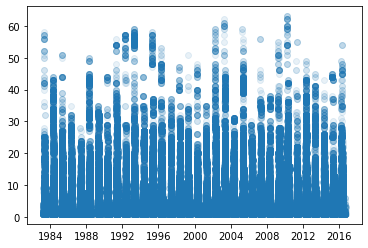

In [50]:
plt.scatter(x,y, alpha = 0.1)

# Regessions

In [163]:
from numpy.polynomial.polynomial import polyfit

regressor = LinearRegression()  

# Geog 
geog = 'sub-region'

# Get results

labels = []
r2_list = []
coef_list = []
p_list = []
df_out = pd.DataFrame()

for label, df_c in df.groupby(geog):
    
    # Get Data
    X_year = np.array(df_c.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df_c.groupby('year')['tot_intensity'].count()).reshape((-1, 1))
    
    # Regress
    model = sm.OLS(Y_stats, X_year).fit()
    coef = model.params[0]
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    # Make lists
    labels.append(label)
    r2_list.append(r2)
    coef_list.append(coef)
    p_list.append(p)
#     print(label)
#     print(model.summary())
    
# Make data frame
df_out[geog] = labels
df_out['r2'] = r2_list
df_out['slope'] = coef_list
df_out['p_value'] = [round(elem, 4) for elem in p_list]

In [164]:
print('Reg. results for average annual severity by year 1983 - 2016')
df_out

Reg. results for average annual severity by year 1983 - 2016


,sub-region,r2,slope,p_value
0,Australia and New Zealand,0.544792,0.001754,0.0000
1,Central Asia,0.926613,0.091722,0.0000
2,Eastern Asia,0.724906,0.072440,0.0000
3,Eastern Europe,0.307411,0.003836,0.0005
4,Latin America and the Caribbean,0.912087,0.100651,0.0000
5,Northern Africa,0.977266,1.490040,0.0000
6,Northern America,0.922537,0.076735,0.0000
7,Northern Europe,NaN,0.000502,NaN
8,South-eastern Asia,0.768170,0.092294,0.0000
9,Southern Asia,0.976530,8.020171,0.0000


In [155]:
print(len(df_out))
df_out_sub = df_out[df_out['r2'] > 0]
print(len(df_out_sub))

7028
6264


Text(0, 0.5, 'Number of cities')

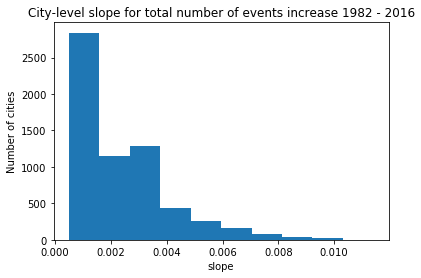

In [162]:
plt.hist(df_out_sub['slope'])
plt.title('City-level slope for total number of events increase 1982 - 2016')
plt.xlabel('slope')
plt.ylabel('Number of cities')

In [139]:
data = df[df['sub-region'] == 'Southern Asia']
year = np.array(data.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
stats = np.array(data.groupby('year')['tot_intensity'].mean()).reshape((-1, 1))

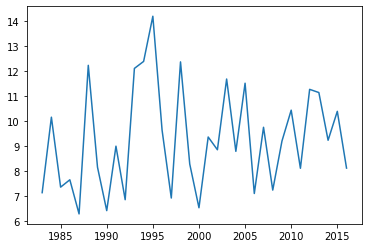

In [140]:
plt.plot(year, stats)